# Introduction 

**<font size="4">Evaluation</font>**
<br>

In real life, physicians diagnose pneumonia through X-ray images with naked eyes. However, Deep Learning can help diagnosis and may be more accurate because Deep Learning can separate image features into tiny pieces that the naked eye could not make. In addition to hospital diagnosis, the class 1 precision should be nearly 100%, or there would be a misdiagnosis in healthy patients, resulting in unnecessary cancer treatment.
<br>


**<font size="4">Purpose</font>**
<br>

Create a Deep Learning Convolutional Neural Network(CNN) model that can predict pneumonia with chest X-ray images based on 5856 images

# Material and Methods

**<font size="4">Data</font>**
<br>

Original images came from Daniel Kermany, Kang Zhang, and Michael Goldbaum groups that published in Mendeley: https://data.mendeley.com/datasets/rscbjbr9sj/2
This is a data processed chest X-ray images version of it made of Paul Mooney, the data is from Kaggle: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
<br>

**<font size="4">Features</font>**
1. **Normal** (**class 0**)
<br>
2. **Pneumonia**  (Bacterial or Viral)(all considered as **class 1**): If needed, we can create a new CNN model that identify Bacterial or Viral Pneumonia from class 1 Pneumonia

**<font size="4">Modelling</font>**
<br>

Two models have been implemented: (1.) regular Convolutional Neural Networks and (2.) Convolutional Neural Networks with Data Augmentation


## Checking GPU and GPU related Libaries Version in the Jupyter Notebook 

In [1]:
#check python version
from platform import python_version

print(python_version())

3.9.12


In [2]:
#check tensorflow version
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


print("TF version:", tf.__version__)

TF version: 2.9.1


In [3]:
#check GPU avaliablity (Ps. this requires install tensorflow gpu in anaconda)
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5024018147629071442
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3667263488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5411124595981015903
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
Num GPUs: 1


GPU is sucessfully read

## Importing Libraries/Tools

In [4]:
#File Handling and Manipulating Tools
import random
import os
import datetime

#Exploratory Data Aalysis and Graphing Tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import seaborn as sns
from IPython.display import Image
import random
%load_ext tensorboard

#Deep Learning Tools- Tensorflow and Keras
import tensorflow as tf
import keras
from keras import callbacks
from keras.models import Sequential
from keras.layers import InputLayer
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

#Model Evaluation 
from sklearn import metrics
from sklearn.metrics import accuracy_scor, confusion_matrixㄝclassification_report

## Setting Parameters Values

In [5]:
BATCH_SIZE = 16
IMG_SIZE = 224
CHANNELS = 1
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, CHANNELS)
NUM_EPOCHS = 100 

BATCH_SIZE can be up to 32; however, the GPU memory for Laptop GTX 3060 is only 6GB

## Creating Class and Directory DataFrame for All Images

In [6]:
train_data_dir ="chest_xray/train/"
val_data_dir = "chest_xray/val/"
test_data_dir = "chest_xray/test/"

In [7]:
subfile = ["NORMAL","PNEUMONIA"]

def load_file(data_dir):
    data =[]
    for label in subfile: 
        path = os.path.join(data_dir , label)
        for img_name in os.listdir(path):
            if label == subfile[0]:
                data.append((path+"/"+img_name, 0))
            elif label ==subfile[1]:
                data.append((path+"/"+img_name, 1))

    data = pd.DataFrame(data)
    data.columns = ["Filename","Pneumonia"]
    return(data)

In [8]:
train_data = load_file(data_dir=train_data_dir)
val_data   = load_file(data_dir=val_data_dir)
test_data  = load_file(data_dir=test_data_dir) 
print(len(train_data),len(val_data),len(test_data))

5216 16 624


Since the train, validation and test data in the files are having not ideal data ratio (89.07%,0.27%,10.66%), this can lead to incorrect(inprecise) callbacks, so we will rearrange them to a 70%, 20% and 10% ratio

# Results - Visualization 

## Pie Chart for Pneumonia and Healthy X-ray Image

In [9]:
all_data = pd.concat([train_data,val_data,test_data],ignore_index=True)

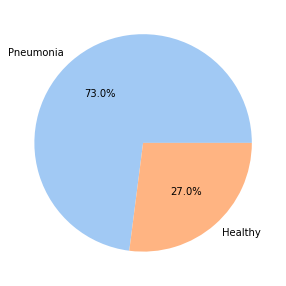

In [10]:
fig, ax= plt.subplots(figsize=(5,5))
colors = sns.color_palette('pastel')
ax.pie(data=all_data, x= all_data["Pneumonia"].value_counts(),labels = ["Pneumonia","Healthy"], colors = colors, autopct='%.1f%%');

# Results - Deep Learning

## Data Preprocessing

### Converting Pneumonia Class Labels into Boolean Labels

In [11]:
Condition = np.array([0,1])
labels = all_data["Pneumonia"].to_numpy()
boolean_labels = [label == Condition for label in labels]

In [12]:
X = all_data["Filename"]
y = np.array(boolean_labels)

###  Spliting Images into Train, Valid and Test Groups

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=5)    
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.22, random_state=5) # 0.2*0.9 ~= 0.20
print(len(X_train), len(y_train), len(X_val), len(y_val), len(X_test),  len(y_test))

4110 4110 1160 1160 586 586


The ratio of train, validation and test group is around 70%, 20% and 10%

In [14]:
#Check if train, valid and test groups are having identifical class number 
unique, counts = np.unique(y_train[:,1],return_counts=True)
print("The ratio of Pneumonia images in Train data: ",(counts[1]/counts.sum()*100).round(2), "%")
unique, counts = np.unique(y_val[:,1],return_counts=True)
print("The ratio of Pneumonia images in Valid data: ",(counts[1]/counts.sum()*100).round(2), "%")
unique, counts = np.unique(y_test[:,1],return_counts=True)
print("The ratio of Pneumonia images in Test  data: ",(counts[1]/counts.sum()*100).round(2), "%")

The ratio of Pneumonia images in Train data:  72.94 %
The ratio of Pneumonia images in Valid data:  71.47 %
The ratio of Pneumonia images in Test  data:  76.11 %


The class 0 and class 1 ratio around the train, valid and test groups are identifical 

### Glancing Train Data Images Randomly and Their Image Size 

In [15]:
def show_9_random_images(data):
    plt.figure(figsize=(7,5))
    for num in range(9):
        n = random.randint(0, len(data["Filename"]))
        ax = plt.subplot(4, 3, num+1)
        
        img = plt.imread(data["Filename"][n])
        plt.imshow(img)
        
        if data["Pneumonia"][n] == 1:
            titlname = ("Pneumonia", imread(train_data["Filename"][n]).shape)
        else:
            titlname = ("Normal", imread(train_data["Filename"][n]).shape)
           
            
        plt.title(titlname)
        plt.axis('off')
        plt.tight_layout(pad = 0.6)

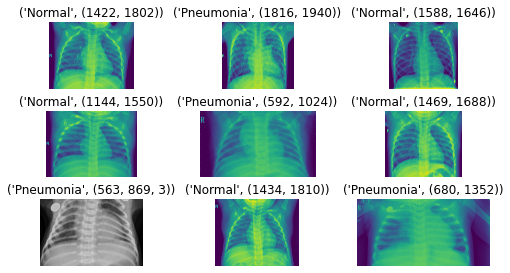

In [16]:
show_9_random_images(train_data)

### Reading, Decoding, Normalizing, and Resizing Image File

In [17]:
def process_images(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
    return image

In [18]:
def image_label(image_path, label):
    image = process_images(image_path)
    return image, label

###  Creating Data Batches

In [19]:
def create_batch(X, y=None, batch_size= BATCH_SIZE, valid_data=False, test_data=False):
    if test_data:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch = data.map(process_images).batch(BATCH_SIZE)
        return data_batch

    elif valid_data:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y))) 
        data_batch = data.map(image_label).batch(BATCH_SIZE)
        return data_batch

    else:

        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y))) 
        data = data.shuffle(buffer_size = len(X)) 
        data_batch = data.map(image_label).batch(BATCH_SIZE)
        return data_batch

In [20]:
tensor_train_data = create_batch(X_train, y_train)
tensor_val_data = create_batch(X_val, y_val, valid_data=True)
tensor_test_data = create_batch(X_test, y_test, test_data=True)
tensor_train_data.element_spec

(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 2), dtype=tf.bool, name=None))

### Building CNN Model Layers

1. The `MaxPool` is not utilized, but the Conv2D layer will have higher `strides = 2` (default = 1). As a reason, the article (https://arxiv.org/abs/1412.6806) has suggested to remove the `MaxPool` and to increase the `strides` size can be a good way to downsampling the spatial dimensions of the volume

2.`kernel_initializer = "he_uniform"` is optimized for `activation="relu"`

In [21]:
def create_model(input_shape = INPUT_SHAPE):
    
    model = keras.Sequential()
    model.add(InputLayer(INPUT_SHAPE))
    model.add(Conv2D(32,(3,3), activation="relu", padding="same",strides = 2, kernel_initializer = "he_uniform"))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3), activation="relu", padding="same",strides = 2, kernel_initializer = "he_uniform"))
    model.add(Dropout(rate=0.1))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3), activation="relu", padding="same",strides = 2, kernel_initializer = "he_uniform"))
    model.add(Dropout(rate=0.2))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3), activation="relu", padding="same",strides = 2, kernel_initializer = "he_uniform"))
    model.add(Dropout(rate=0.2))
    model.add(BatchNormalization())
    
   
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu', kernel_initializer = "he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.5))
    model.add(Dense(64, activation='relu', kernel_initializer = "he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.5))
    model.add(Dense(2, activation="sigmoid"))

    model.compile(
       loss=tf.keras.losses.BinaryCrossentropy(),
       optimizer=tf.keras.optimizers.Adam(),
       metrics=["accuracy"]
    )
    
    return model

In [22]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 56, 56, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 56, 56, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       7

### Callback Function

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=5, restore_best_weights=True)

def create_tensorboard_callback():
  logdir = os.path.join(r"C:\Users\dakfo\MLProject\sample_project_1\x-ray-logs",
                        #getting a log file to track the history everytime
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

## Trainng CNN Model - Part 1

In [24]:
def train_model():

  #create model
  model = create_model()

  #create new tensorboard session everythime 
  tensorboard = create_tensorboard_callback()

   #fit the model and store the learning curve to the history too
  history = model.fit(x= tensor_train_data,
            epochs= NUM_EPOCHS,
            validation_data = tensor_val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  return model, history

In [25]:
model, history = train_model() 

Epoch 1/100
257/257 [==============================] - 37s 89ms/step - loss: 0.3643 - accuracy: 0.8796 - val_loss: 0.4804 - val_accuracy: 0.7888
Epoch 2/100
257/257 [==============================] - 20s 76ms/step - loss: 0.2300 - accuracy: 0.9238 - val_loss: 2.7808 - val_accuracy: 0.5328
Epoch 3/100
257/257 [==============================] - 19s 74ms/step - loss: 0.1785 - accuracy: 0.9387 - val_loss: 0.3501 - val_accuracy: 0.8819
Epoch 4/100
257/257 [==============================] - 19s 73ms/step - loss: 0.1683 - accuracy: 0.9438 - val_loss: 0.1579 - val_accuracy: 0.9431
Epoch 5/100
257/257 [==============================] - 19s 74ms/step - loss: 0.1501 - accuracy: 0.9487 - val_loss: 0.3134 - val_accuracy: 0.9112
Epoch 6/100
257/257 [==============================] - 19s 73ms/step - loss: 0.1436 - accuracy: 0.9516 - val_loss: 0.1571 - val_accuracy: 0.9431
Epoch 7/100
257/257 [==============================] - 19s 73ms/step - loss: 0.1116 - accuracy: 0.9618 - val_loss: 0.1588 - val_ac

In [26]:
val_loss, val_score = model.evaluate(tensor_val_data)
print(f"the test loss of the test data is: {val_loss}")
print(f"the accuracy score of the test data is: {val_score}")

73/73 [==============================] - 4s 56ms/step - loss: 0.1080 - accuracy: 0.9647
the test loss of the test data is: 0.10795891284942627
the accuracy score of the test data is: 0.9646551609039307


### M1:Predicting Test Group

In [50]:
preds = model.predict(tensor_test_data)
preds = np.argmax(preds, axis=-1)

37/37 [==============================] - 2s 55ms/step


In [28]:
test_y = [n.astype(int) for n in y_test]
test_y = np.argmax(test_y, axis=-1)

### M1:Test Results 

#### M1:Confusion Matrix

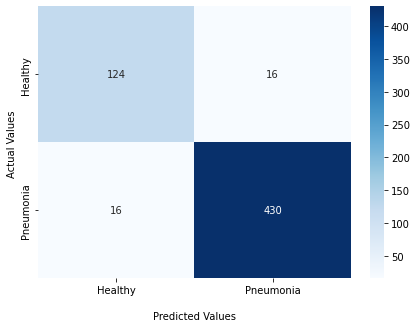

In [29]:
cm  = confusion_matrix(test_y, preds)
plt.figure(figsize=(7,5))

ax = sns.heatmap(cm, annot = True, cmap='Blues',fmt='.3g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Healthy','Pneumonia'])
ax.yaxis.set_ticklabels(['Healthy','Pneumonia'])

plt.show()

#### M1:Accuracy and Classification Report 

In [30]:
print(classification_report(test_y, preds))
print("Accuracy of the Model:",accuracy_score(test_y, preds)*100,"%")

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       140
           1       0.96      0.96      0.96       446

    accuracy                           0.95       586
   macro avg       0.92      0.92      0.92       586
weighted avg       0.95      0.95      0.95       586

Accuracy of the Model: 94.53924914675767 %


#### M1:Learninig Curve

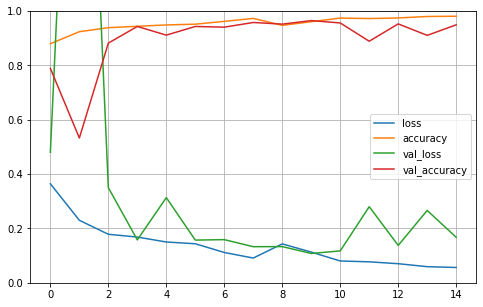

In [31]:
pd.DataFrame(history.history).plot(figsize =(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## Trainng CNN Model - Part 2

### Data Augmentation

Some common data augmentation can be retrieved from: 
https://www.tensorflow.org/api_docs/python/tf/keras/layers

In [32]:
data_augmentation = tf.keras.Sequential([
    
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2),width_factor=(-0.2, 0.2)),  #postive = zoomed out; negative = zoomed out 0.1=10%
  tf.keras.layers.RandomHeight(factor=(-0.1, 0.1)),
  tf.keras.layers.RandomWidth(factor=(-0.1, 0.1)),
  tf.keras.layers.RandomBrightness(factor=(-0.2, 0.2)),
  tf.keras.layers.RandomRotation(factor=(-0.2, 0.2))
  ]
)

####  Creating Data Batches Version 2 (Data Augmentation)

**Data Augmentation** only affect create_batch function 
<br>
Data augemntation can also resize/normatlize the images, but to elminate any confusion, this function is not been implemented 

In [33]:
def create_batch_2(X, y=None, batch_size= BATCH_SIZE, valid_data=False, test_data=False):
    if test_data:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch = data.map(process_images).batch(BATCH_SIZE)
        return data_batch

    elif valid_data:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y))) 
        data_batch = data.map(image_label).batch(BATCH_SIZE)
        return data_batch

    else:

        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y))) 
        data = data.shuffle(buffer_size = len(X)) 
        data_batch = data.map(image_label).map(lambda X, y: (data_augmentation(X), y)).batch(BATCH_SIZE) #only train data is having data augmentation
        return data_batch

In [34]:
tensor_train_data_2 = create_batch_2(X_train, y_train) 
tensor_val_data_2 = create_batch_2(X_val, y_val, valid_data=True) #tensor_valid_data = tensor_valid_data_2 
tensor_test_data_2 = create_batch_2(X_test, y_test, test_data=True)#tensor_test_data = tensor_test_data_2 
tensor_train_data_2.element_spec

(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 2), dtype=tf.bool, name=None))

In [35]:
model_2, history_2 = train_model() 

Epoch 1/100
257/257 [==============================] - 20s 73ms/step - loss: 0.3601 - accuracy: 0.8832 - val_loss: 0.2238 - val_accuracy: 0.9259
Epoch 2/100
257/257 [==============================] - 19s 73ms/step - loss: 0.2310 - accuracy: 0.9236 - val_loss: 0.1984 - val_accuracy: 0.9164
Epoch 3/100
257/257 [==============================] - 19s 73ms/step - loss: 0.1878 - accuracy: 0.9360 - val_loss: 0.5137 - val_accuracy: 0.8009
Epoch 4/100
257/257 [==============================] - 19s 73ms/step - loss: 0.1462 - accuracy: 0.9472 - val_loss: 0.1612 - val_accuracy: 0.9448
Epoch 5/100
257/257 [==============================] - 19s 73ms/step - loss: 0.1357 - accuracy: 0.9518 - val_loss: 0.1154 - val_accuracy: 0.9543
Epoch 6/100
257/257 [==============================] - 19s 73ms/step - loss: 0.1485 - accuracy: 0.9482 - val_loss: 0.2798 - val_accuracy: 0.8966
Epoch 7/100
257/257 [==============================] - 19s 73ms/step - loss: 0.1583 - accuracy: 0.9455 - val_loss: 0.1421 - val_ac

In [36]:
val_loss, val_score = model_2.evaluate(tensor_val_data)
print(f"the test loss of the test data is: {val_loss}")
print(f"the accuracy score of the test data is: {val_score}")

73/73 [==============================] - 4s 56ms/step - loss: 0.1154 - accuracy: 0.9543
the test loss of the test data is: 0.11535364389419556
the accuracy score of the test data is: 0.9543103575706482


### M2:Predicting Test Group

In [51]:
preds_2 = model_2.predict(tensor_test_data_2)
preds_2 = np.argmax(preds_2, axis=-1)

37/37 [==============================] - 2s 56ms/step


### M2:Test Results 

#### M2:Confusion Matrix 

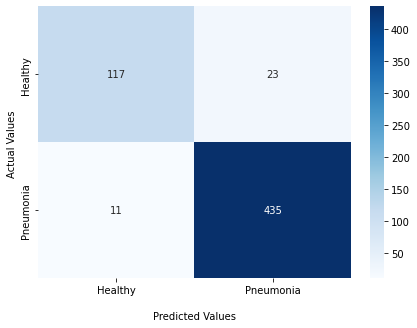

In [52]:
cm  = confusion_matrix(test_y, preds_2)
plt.figure(figsize=(7,5))

ax = sns.heatmap(cm, annot = True, cmap='Blues',fmt='.3g')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Healthy','Pneumonia'])
ax.yaxis.set_ticklabels(['Healthy','Pneumonia'])

plt.show()

#### M2:Accuracy and Classification Report 

In [55]:
print(classification_report(test_y, preds_2))
print("Accuracy of the Model:",accuracy_score(test_y, preds_2)*100,"%")

              precision    recall  f1-score   support

           0       0.91      0.84      0.87       140
           1       0.95      0.98      0.96       446

    accuracy                           0.94       586
   macro avg       0.93      0.91      0.92       586
weighted avg       0.94      0.94      0.94       586

Accuracy of the Model: 94.19795221843003 %


#### M2: Learninig Curve

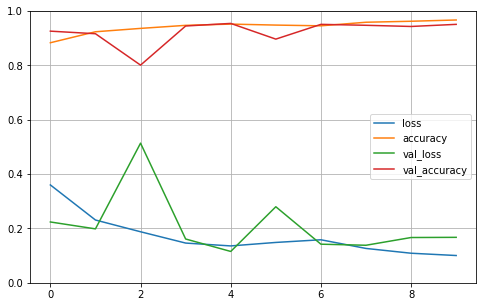

In [54]:
pd.DataFrame(history_2.history).plot(figsize =(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

**<font size="4">In Two CNNs training ((Model 1) one without data augmentation and (Model 2) one with data augmentation)</font>**

**<font size="3">Statistics:</font>**
<br>

With both models on **1000 patients** prediction (class 0:class 1 = 21.8%:78.2%):

1. **94%** of patients can predict into correct class 
2. **Class 1 recall is 96+%**, less likely to uncover Pneumonia patients
* Model 2 got better class 1 recall (98%)
3. **The class 0 recall is 85+%**, this model is less effective on predicting class 0 results 
* Model 1 got better class 2 recall (89%)
<br>

**<font size="3">Train Loss and Validation Loss:</font>**
1. In both models, the Train Loss and Validation Loss both reduced throughout the time. However, it can still have a bump in the middle stage that overfit the training dataset
2. Both models seem training accuracy is higher than validation accuracy in each epoch; however, model 1 is more obvious(overfitting); **model 2 regularizes better**.


# Conclusion 

**<font size="3">Overall:</font>**
1. **two models shared the same pattern**
2. Two models both can screen out **96% of real Pneumonia patients will be predicted as Pneumonia candidates**
3. The models predicted **candidates** for Pneumonia patients with **5% chance chance to be no Pneumonia**
4. The loss function can all be improved. They all have bumps with both models 

# Discussion

**<font size="4">Reason:</font>**
1. There is more Pneumonia dataset (73%:27%), so they tend to predict better on the class 1 dataset
2. There are no sufficient datasets 4110, 1160 and 586 images on the train, validation and test groups, so the value in the classification report can only show a general idea.
<br>

**<font size="4">Interpretation:</font>**
<br>

If these two models are being utilized for diagnosis, we should **choose model 2 over model 1**. They shared similar accuracy, but X-ray images can be biased to the model of X-ray machine or operators, and model 2 regularize better because it is trained based on data augmentation. This means model 2 can predict better even if the X-ray images show slightly brighter, darker, and even some X-ray image shifting happened. 
<br>


**<font size="4">To Improve the CNN Models Inference:</font>**

**<font size="3">Improve Both Models:</font>** 

1. **Increase the data size**. Since we combine the default train, validation and test datasets, even it may have a better callback function and better classification reports. It tradeoff some training data (model trains fewer images). Increasing the dataset to train can reduce the loss and avoid bumping.
2. **Increasing the CNNs models' complexity** can also make the loss function have fewer bumps; however, data size should increase first
3. If the dataset is increased, **trying "elu" activation, "increasing dropout rate", and "more data augmentation parameters"** can all help with regularizing the models since the model has a bit of overfitting. Although the current model 2 has less overfitting than model 1, it still does not reach the optimal value(the training group has 1% higher accuracy). 
4. **Label the pneumonia groups with their seriousness (level 1 to level 4)**, so the model can weigh the image's features better
<br>

Even the current model predicts class 1 better, but we may not need to balance the class 0 and class 1 data. For diagnosis purposes, physicians should always double-check "class 1" prediction to prevent any misdiagnosis of healthy patients(Those pneumonia patients assumed as healthy patients still have a chance to be diagnosed by their symptoms and further diagnosis schedule in their life). Those patients being predicted as class 1 may also have presented some signals(considered as the developing or initial stage) to develop pneumonia. It can be a kind of precaution for them. 